# Catalogue Fitting

Synference has a method specifically for fitting catalogues of sources - `fit_catalogue`.

This is designed to be a flexible and fast way to fit your full catalogue.

It can handle:
1. Transforming observations to match the expected model features.
2. Prior predictive checks/outlier detection to remove sources that are unlikely to be well modelled.
3. Optional imputation of missing data.
4. Rapid posterior inference using trained model.
5. Optional SED recovery (see [this notebook](sed_recovery.ipynb) for more details).
6. Returning structured results.

In [1]:
from synthesizer import get_grids_dir
import os
from unyt import Jy
import numpy as np
from IPython.display import display
from synference import SBI_Fitter, load_unc_model_from_hdf5

print(get_grids_dir())

available_grids = os.listdir(get_grids_dir())
if "test_grid.hdf5" not in available_grids:
    cmd = f"synthesizer-download --test-grids --destination {get_grids_dir()}"
    os.system(cmd)

library_path = os.path.join(get_grids_dir(), "test_grid.hdf5")

/Users/user/Library/Application Support/Synthesizer/grids


In [2]:
?SBI_Fitter.fit_catalogue

Signature:
SBI_Fitter.fit_catalogue(
    self,
    observations: Union[astropy.table.table.Table, pandas.core.frame.DataFrame],
    columns_to_feature_names: dict = None,
    flux_units: Union[str, unyt.array.unyt_quantity, NoneType] = None,
    missing_data_flag: Any = -99,
    quantiles: list = [0.16, 0.5, 0.84],
    sample_method: str = 'direct',
    sample_kwargs: dict = {},
    num_samples: int = 1000,
    timeout_seconds_per_row: int = 5,
    override_transformations: dict = {},
    append_to_input: bool = True,
    return_feature_array: bool = False,
    recover_SEDs: bool = False,
    plot_SEDs: bool = False,
    check_out_of_distribution: bool = True,
    simulator: Optional[synference.library.GalaxySimulator] = None,
    outlier_methods: list = ['iforest', 'feature_bagging', 'ecod', 'knn', 'lof', 'gmm', 'mcd', 'kde'],
    missing_data_mcmc: bool = False,
    missing_data_mcmc_params: dict = {'ini_chi': 5.0, 'max_chi2': 50.0, 'nmc': 100, 'nposterior': 1000, 'tmax_all': 10, 've

We'll use a subset of the JADES spectroscopic catalogue used in the synference paper for this example.

In [3]:
from astropy.table import Table

cat = Table.read("../example_models/cats/jades_spec_catalogue_subset.fits")

The first step is the same as our SED recovery example - we will load our trained model and the noise model used to train the model. We need the noise model to transform our observations to match the model features.

In [4]:
library_path = "../example_models/bpass_db_v4/grid_BPASS_Chab_DenseBasis_SFH_0.01_z_14_logN_2.7_Calzetti_v3_multinode.hdf5"  # noqa: E501

fitter = SBI_Fitter.load_saved_model(
    model_file="../example_models/bpass_db_v4", library_path=library_path, device="cpu"
)

nm_path = (
    "../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_params_empirical_noise_models.h5"
)
noise_models = load_unc_model_from_hdf5(nm_path)

fitter.feature_array_flags["empirical_noise_models"] = noise_models

2025-11-06 17:43:54,193 | synference | INFO     | Loaded model from ../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_posterior.pkl.
2025-11-06 17:43:54,194 | synference | INFO     | Device: cpu
2025-11-06 17:43:54,235 | synference | WARNING  | IndexError when trying to set train/test arrays. 


Now we need to explain our catalogue to synference. We create a 'conversion_dict' dictionary which maps the feature names to columns in the table.
**The expected column names for flux are the SVO format filter names, e.g. JWST/NIRCam.F070W, or just F070W if it is unambiguous.**
**For flux errors it is the same, but with 'unc_' prefixed, e.g. unc_JWST/NIRCam.F070W or unc_F070W.**
**Any other features (e.g. redshift) should be mapped to the column name in the catalogue.**


In this case our catalogue is almost in the correct format, so we just need to convert the band names to include the facility and instrument. We do this by getting the band names from the fitted model (`fitter.feature_names`) and replacing the relevant parts of the strings.

We then create our conversion dictionary to map from e.g. 'unc_F200W' to 'unc_JWST/NIRCam.F200W'.

In [5]:
def band_to_instrument(band):
    """Band name to instrument mapping."""
    if band in ["F435W", "F606W", "F775W", "F814W", "F850LP"]:
        return f"HST/ACS_WFC.{band}"
    return f"JWST/NIRCam.{band}"


bands = [
    i.split(".")[-1]
    for i in fitter.feature_names
    if not (i.startswith("unc_") or i.startswith("redshift"))
]

print(bands)

conversion_dict = {band: band_to_instrument(band) for band in bands}
conversion_dict.update({f"unc_{band}": f"unc_{band_to_instrument(band)}" for band in bands})
conversion_dict["redshift"] = "redshift"

conversion_dict

['F435W', 'F606W', 'F775W', 'F814W', 'F850LP', 'F090W', 'F115W', 'F150W', 'F200W', 'F277W', 'F335M', 'F356W', 'F410M', 'F444W']


{'F435W': 'HST/ACS_WFC.F435W',
 'F606W': 'HST/ACS_WFC.F606W',
 'F775W': 'HST/ACS_WFC.F775W',
 'F814W': 'HST/ACS_WFC.F814W',
 'F850LP': 'HST/ACS_WFC.F850LP',
 'F090W': 'JWST/NIRCam.F090W',
 'F115W': 'JWST/NIRCam.F115W',
 'F150W': 'JWST/NIRCam.F150W',
 'F200W': 'JWST/NIRCam.F200W',
 'F277W': 'JWST/NIRCam.F277W',
 'F335M': 'JWST/NIRCam.F335M',
 'F356W': 'JWST/NIRCam.F356W',
 'F410M': 'JWST/NIRCam.F410M',
 'F444W': 'JWST/NIRCam.F444W',
 'unc_F435W': 'unc_HST/ACS_WFC.F435W',
 'unc_F606W': 'unc_HST/ACS_WFC.F606W',
 'unc_F775W': 'unc_HST/ACS_WFC.F775W',
 'unc_F814W': 'unc_HST/ACS_WFC.F814W',
 'unc_F850LP': 'unc_HST/ACS_WFC.F850LP',
 'unc_F090W': 'unc_JWST/NIRCam.F090W',
 'unc_F115W': 'unc_JWST/NIRCam.F115W',
 'unc_F150W': 'unc_JWST/NIRCam.F150W',
 'unc_F200W': 'unc_JWST/NIRCam.F200W',
 'unc_F277W': 'unc_JWST/NIRCam.F277W',
 'unc_F335M': 'unc_JWST/NIRCam.F335M',
 'unc_F356W': 'unc_JWST/NIRCam.F356W',
 'unc_F410M': 'unc_JWST/NIRCam.F410M',
 'unc_F444W': 'unc_JWST/NIRCam.F444W',
 'redshift': 're

Now we can run the inference. We specify the catalogue table, the conversion dictionary, the input flux units (Jy), and then we have some choices.

We can choose to:

1. Run predictive checks to remove outliers. 
2. Impute or remove missing data.
3. Run posterior inference, setting the number of posterior samples to draw.    
4. Recover SEDs for each source.

In [6]:
fitter.recreate_simulator_from_library(
    override_library_path=library_path, override_grid_path="test_grid.hdf5"
)

post_tab = fitter.fit_catalogue(
    cat,
    columns_to_feature_names=conversion_dict,
    flux_units=Jy,
    check_out_of_distribution=False,
    recover_SEDs=False,
    missing_data_flag=np.nan,
    num_samples=300,
    append_to_input=False,
)

Overriding internal library name to library passed in directory path.


Failed to load cosmology from HDF5. Using Planck18 instead.
params: {'fesc_ly_alpha': 0.0, 'tau_v': 'tau_v', 'dust_curve': <synthesizer.emission_models.transformers.dust_attenuation.Calzetti2000 object at 0x11112ada0>, 'dust_emission': <synthesizer.emission_models.dust.emission.Greybody object at 0x11112afe0>}
Updated filters: ['HST/ACS_WFC.F435W', 'HST/ACS_WFC.F606W', 'HST/ACS_WFC.F775W', 'HST/ACS_WFC.F814W', 'HST/ACS_WFC.F850LP', 'JWST/NIRCam.F090W', 'JWST/NIRCam.F115W', 'JWST/NIRCam.F150W', 'JWST/NIRCam.F200W', 'JWST/NIRCam.F277W', 'JWST/NIRCam.F335M', 'JWST/NIRCam.F356W', 'JWST/NIRCam.F410M', 'JWST/NIRCam.F444W']
2025-11-06 17:43:58,948 | synference | INFO     | Simulator recreated from grid at ../example_models/bpass_db_v4/grid_BPASS_Chab_DenseBasis_SFH_0.01_z_14_logN_2.7_Calzetti_v3_multinode.hdf5.
2025-11-06 17:43:58,949 | synference | INFO     | Auto applying inverse log10 transform for log10_Av.
2025-11-06 17:43:58,949 | synference | INFO     | Auto applying inverse log10 tran

Sampling from posterior: 100%|██████████| 76/76 [00:07<00:00, 10.30it/s]

2025-11-06 17:44:06,436 | synference | INFO     | Obtained posterior samples.


We can look at the output table, which is also an `astropy.table.Table`.

In [7]:
post_tab

ID,log_mass_16,log_mass_50,log_mass_84,log10metallicity_16,log10metallicity_50,log10metallicity_84,log10_Av_16,log10_Av_50,log10_Av_84,log_sfr_16,log_sfr_50,log_sfr_84,sfh_quantile_25_16,sfh_quantile_25_50,sfh_quantile_25_84,sfh_quantile_50_16,sfh_quantile_50_50,sfh_quantile_50_84,sfh_quantile_75_16,sfh_quantile_75_50,sfh_quantile_75_84,log10_mass_weighted_age_16,log10_mass_weighted_age_50,log10_mass_weighted_age_84,log10_floor_sfr_10_16,log10_floor_sfr_10_50,log10_floor_sfr_10_84,log_surviving_mass_16,log_surviving_mass_50,log_surviving_mass_84,beta_16,beta_50,beta_84
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,9.945412635803223,10.08867597579956,10.246087417602538,-3.9599705123901368,-3.822345018386841,-3.527126636505127,-0.3444303774833679,-0.16763148456811905,-0.051856638491153725,0.19906150460243227,0.5163044929504395,0.79324782371521,0.06610634952783585,0.1960180252790451,0.5046142721176148,0.23429921329021455,0.548133909702301,0.7933681750297547,0.6024598693847657,0.8706637620925903,0.960152986049652,3.1790018558502195,3.389127016067505,3.52751877784729,0.15928093910217286,0.5239043533802032,0.7753875875473022,9.710968017578125,9.83228874206543,9.970141830444335,-1.4183131551742554,-1.2812188863754272,-1.146461672782898
2,9.168969268798827,9.347131252288818,9.51943603515625,-3.902289533615112,-3.7490501403808594,-3.5218265438079834,-2.942304754257202,-2.7806901931762695,-2.158247880935669,-1.1161032581329347,-0.7960638999938965,-0.5595312166213989,0.05309537291526797,0.23220784962177277,0.5293524527549743,0.31224308609962464,0.5625556111335754,0.7661829352378845,0.48225550293922426,0.8023932874202728,0.9353961682319641,3.326441583633423,3.528376817703247,3.6742134857177735,-1.174429211616516,-0.8270660638809204,-0.6905264925956726,8.911663627624511,9.067815780639648,9.223719596862793,-1.9044599676132201,-1.777645468711853,-1.5468303728103638
3,10.527242469787598,10.665138721466064,10.836037521362305,-3.5538615131378175,-3.0734246969223022,-2.704142007827759,0.08054785758256912,0.16599462926387787,0.22499593019485473,1.1363530254364014,1.5282281637191772,1.710115966796875,0.0797725859284401,0.24038144201040268,0.5178763747215271,0.30054516792297364,0.5587457120418549,0.8235013127326966,0.7294115400314332,0.9523773789405823,0.9849313807487488,3.0033477306365968,3.1964839696884155,3.3507705402374266,1.087177004814148,1.487818956375122,1.6827284431457519,10.314903373718261,10.440605640411377,10.581503868103027,-0.6845763611793518,-0.469634473323822,-0.27982351660728455
4,10.345759468078613,10.48043966293335,10.598720588684081,-2.97732008934021,-2.625717282295227,-2.3709702682495117,-1.4253325653076172,-0.5456600189208984,-0.2929323160648346,-1.4009947729110717,-1.0387622714042664,-0.6888691687583923,0.0273078490793705,0.1269926056265831,0.3340832114219665,0.16381805121898652,0.32024645805358887,0.531374659538269,0.2945580339431763,0.46002237498760223,0.6166704344749451,3.5548226547241213,3.6577333211898804,3.723507871627808,-1.4512407112121581,-1.1355942487716675,-0.832875099182129,10.061121444702149,10.18647575378418,10.301587905883789,-0.5470767259597779,0.3738689571619034,0.9963069128990173
5,10.516699638366699,10.604579448699951,10.668926582336425,-3.958907642364502,-3.8142200708389282,-3.363072214126587,-0.7297604179382324,-0.47203686833381653,-0.3178341329097748,-0.8949239349365234,-0.40811172127723694,-0.1398295521736145,0.019769234359264375,0.08266295865178108,0.24015001058578492,0.11824064552783967,0.26880592107772827,0.46812015771865845,0.20797146260738372,0.42187364399433136,0.6184006834030151,3.324433879852295,3.4231741428375244,3.472359313964844,-0.8975186681747437,-0.41581933200359344,-0.16108404755592345,10.245614128112793,10.324042320251465,10.384122734069825,-0.5271899485588074,-0.30

And we can plot the star-forming main sequence from the fitted catalogue.

Text(0, 0.5, 'SFR (log M_sun/yr)')

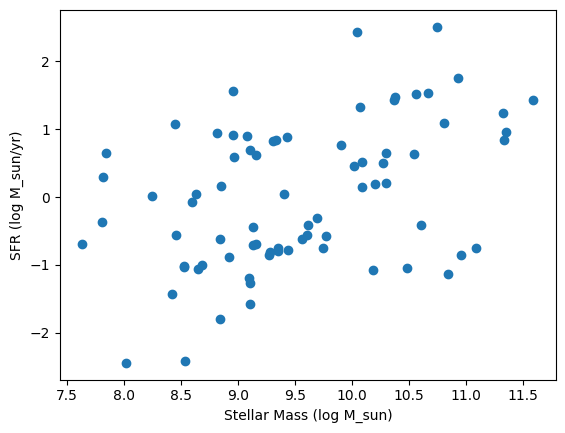

In [8]:
import matplotlib.pyplot as plt

plt.scatter(post_tab["log_mass_50"], post_tab["log_sfr_50"])
plt.xlabel("Stellar Mass (log M_sun)")
plt.ylabel("SFR (log M_sun/yr)")

You may notice some of rows and nans. This is because those rows had missing data that we chose not to impute, which can't be handled by the SBI inference method.

We could set `missing_data_mcmc` to `True` to impute those missing values instead.

We can also recover and plot the SEDs, which we'll do for the first few sources in the catalogue.

In [9]:
post_tab, data = fitter.fit_catalogue(
    cat[:4],
    columns_to_feature_names=conversion_dict,
    flux_units=Jy,
    check_out_of_distribution=False,
    recover_SEDs=True,
    plot_SEDs=True,
    missing_data_flag=np.nan,
    num_samples=300,
    append_to_input=False,
)

WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB

Sampling from posterior:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling from posterior: 100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

2025-11-06 17:44:07,730 | synference | INFO     | Obtained posterior samples.



Recovering SEDs from posterior samples...:   0%|          | 0/4 [00:00<?, ?it/s]

2025-11-06 17:44:08,717 | synference | WARNING  | The following parameters are not used by the simulator: ['log10_Av', 'log_sfr', 'sfh_quantile_25', 'sfh_quantile_50', 'sfh_quantile_75', 'log10_mass_weighted_age', 'log10_floor_sfr_10', 'log_surviving_mass', 'beta', 'Av', 'mass_weighted_age', 'floor_sfr_10']


Running simulator on samples: 100%|██████████| 300/300 [01:13<00:00,  4.09it/s]


2025-11-06 17:45:23,151 | synference | INFO     | Saving SED plot to /Users/user/Documents/PhD/synference/models/BPASS_DenseBasis_v4_final/plots//BPASS_DenseBasis_v4_final_SED_0


Running simulator on samples: 100%|██████████| 300/300 [01:06<00:00,  4.53it/s]7.78s/it]


2025-11-06 17:46:35,958 | synference | INFO     | Saving SED plot to /Users/user/Documents/PhD/synference/models/BPASS_DenseBasis_v4_final/plots//BPASS_DenseBasis_v4_final_SED_1


Running simulator on samples: 100%|██████████| 300/300 [01:31<00:00,  3.27it/s]5.44s/it]


2025-11-06 17:48:14,203 | synference | INFO     | Saving SED plot to /Users/user/Documents/PhD/synference/models/BPASS_DenseBasis_v4_final/plots//BPASS_DenseBasis_v4_final_SED_2


Running simulator on samples: 100%|██████████| 300/300 [02:12<00:00,  2.27it/s]5.23s/it]


2025-11-06 17:50:34,173 | synference | INFO     | Saving SED plot to /Users/user/Documents/PhD/synference/models/BPASS_DenseBasis_v4_final/plots//BPASS_DenseBasis_v4_final_SED_3


Recovering SEDs from posterior samples...: 100%|██████████| 4/4 [06:32<00:00, 98.10s/it] 


If you recover the SEDs then a nested dictionary with the SED posteriors are also returned. Initial key is the source index or ID, then within that there are keys for 'wav', 'fnu_quantiles', 'wav', 'phot_wav', 'phot_fnu_draws' and 'fig'.

In [10]:
data[1].keys()

dict_keys(['wav', 'fnu_quantiles', 'phot_wav', 'phot_fnu_draws', 'fig'])

Here are the SED plots:

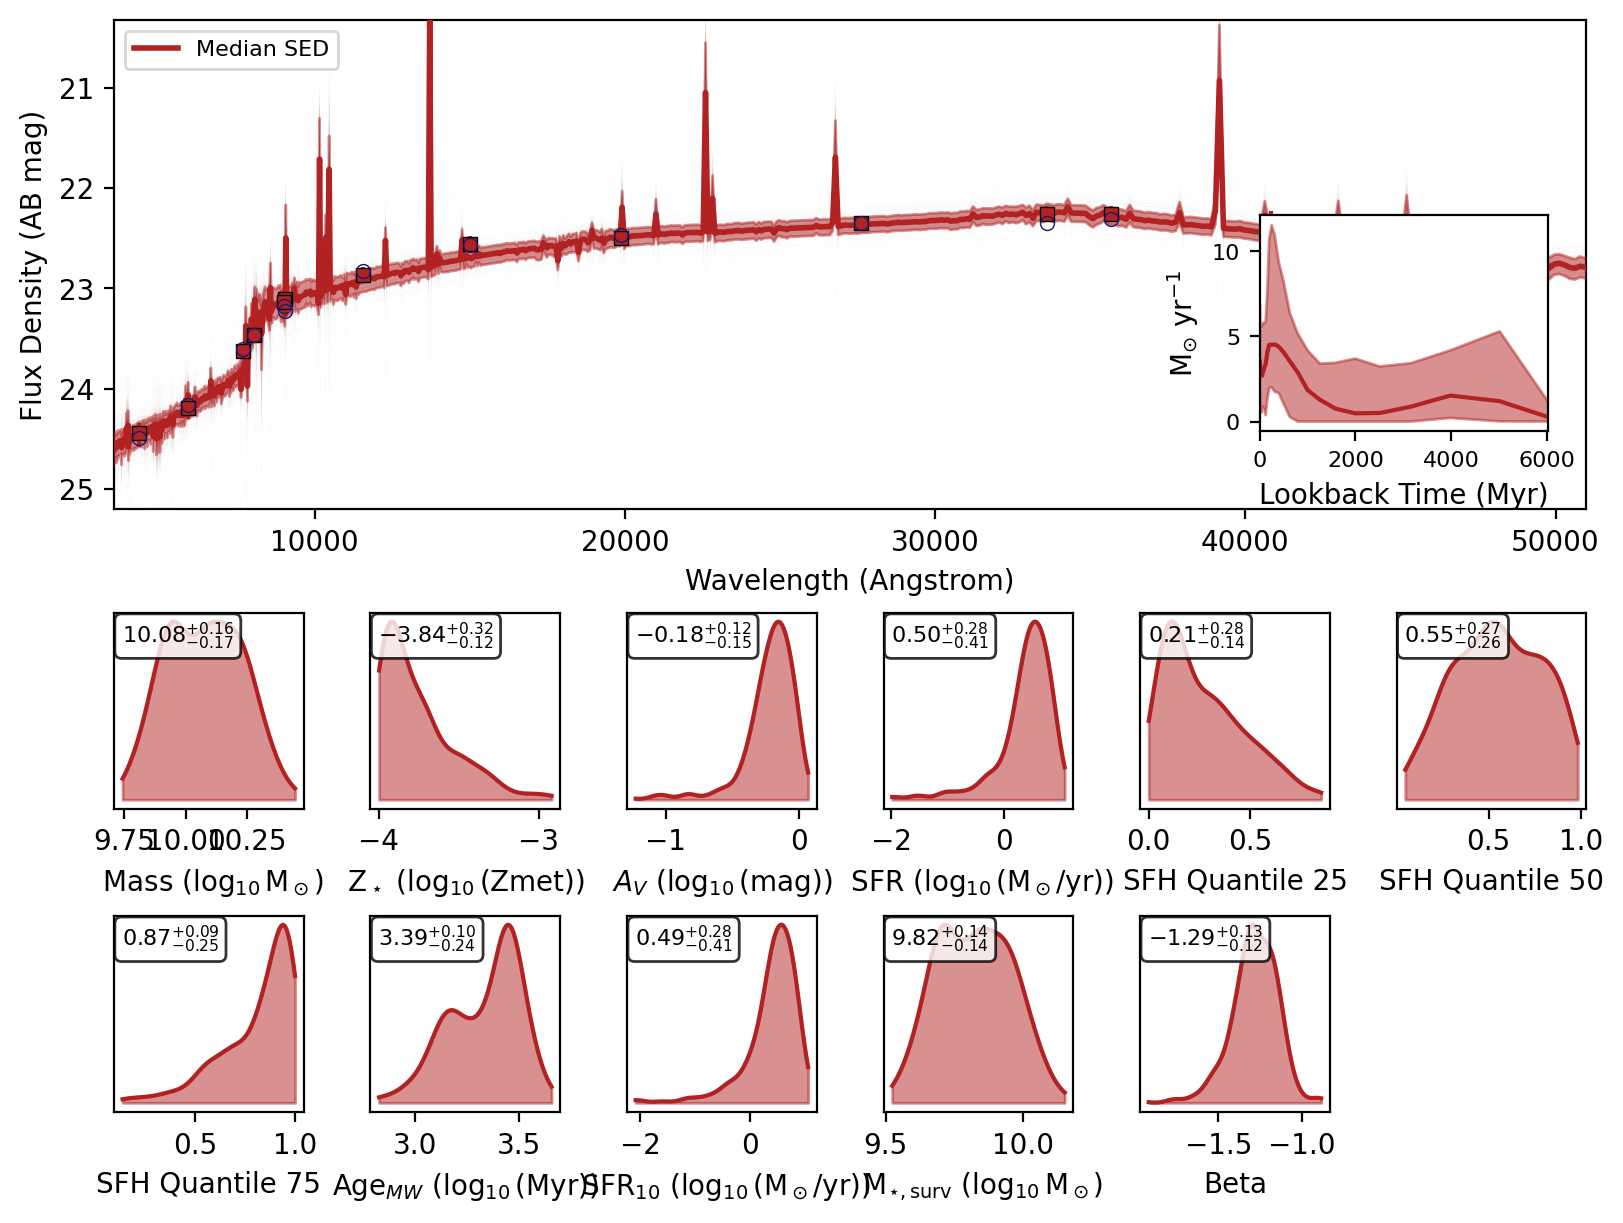

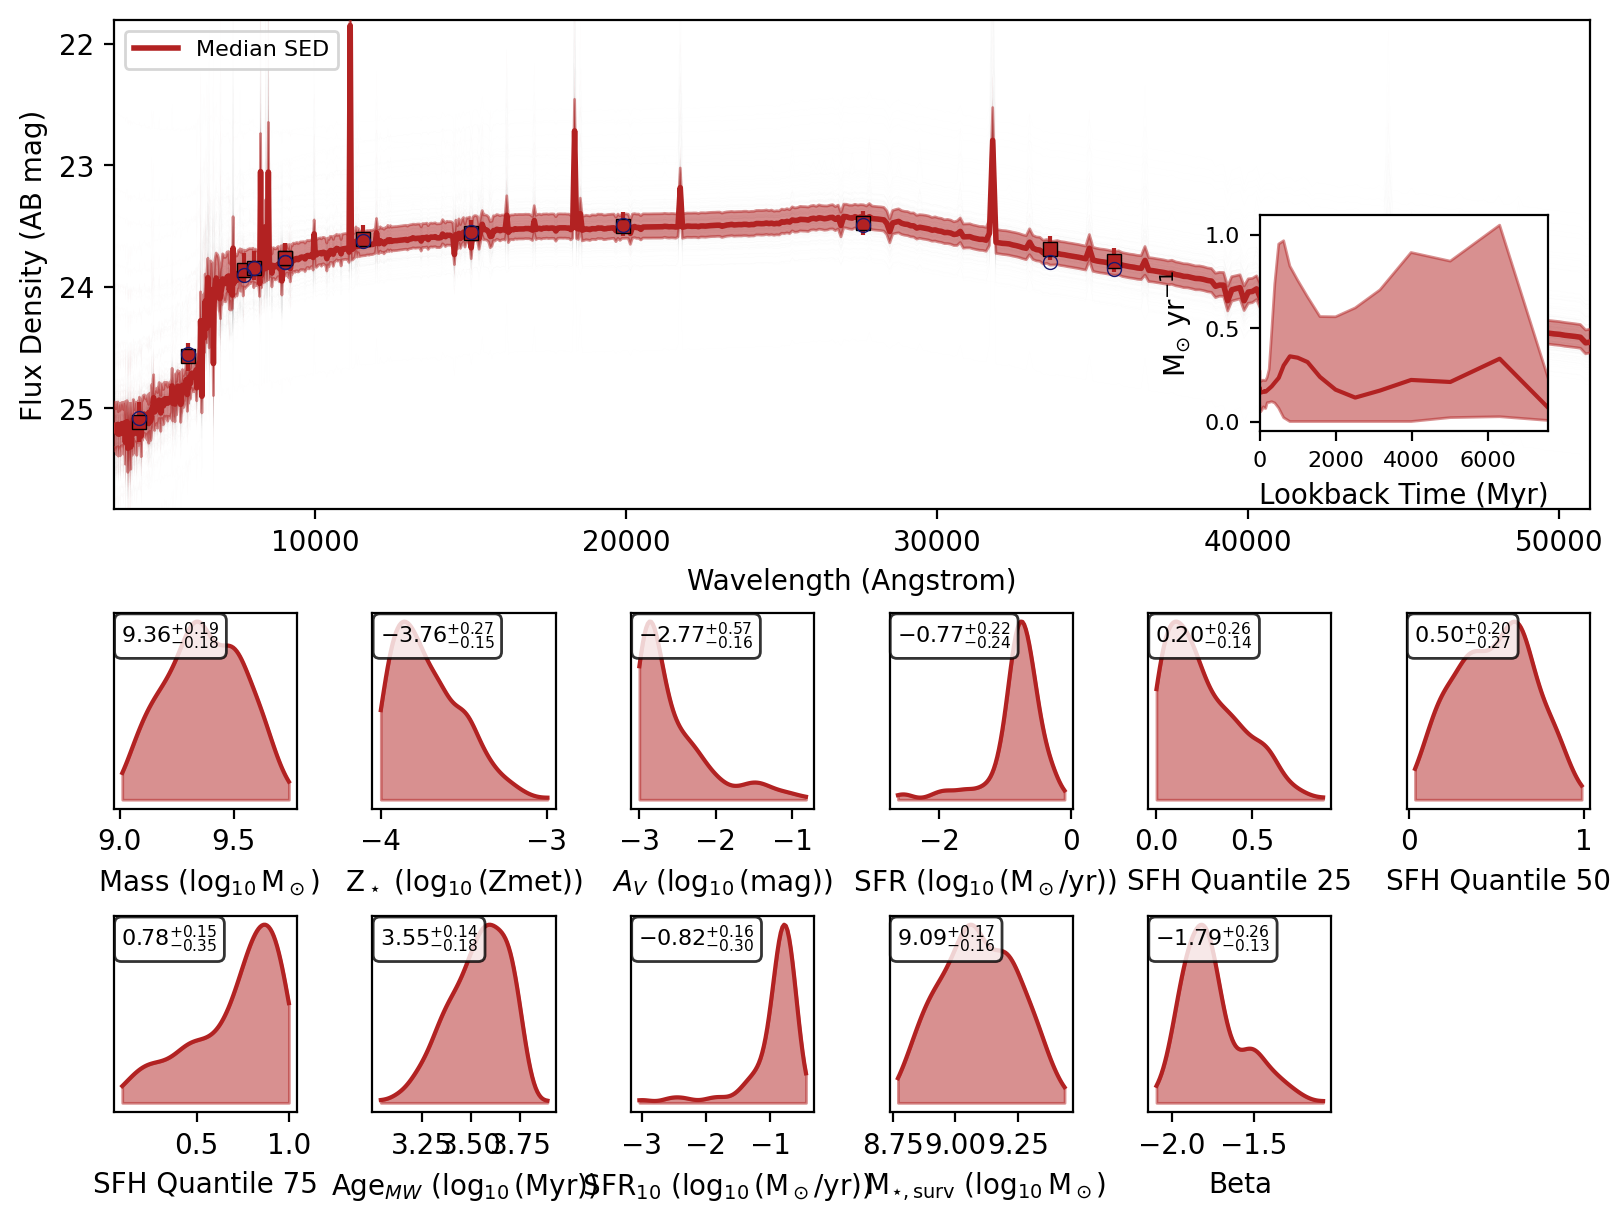

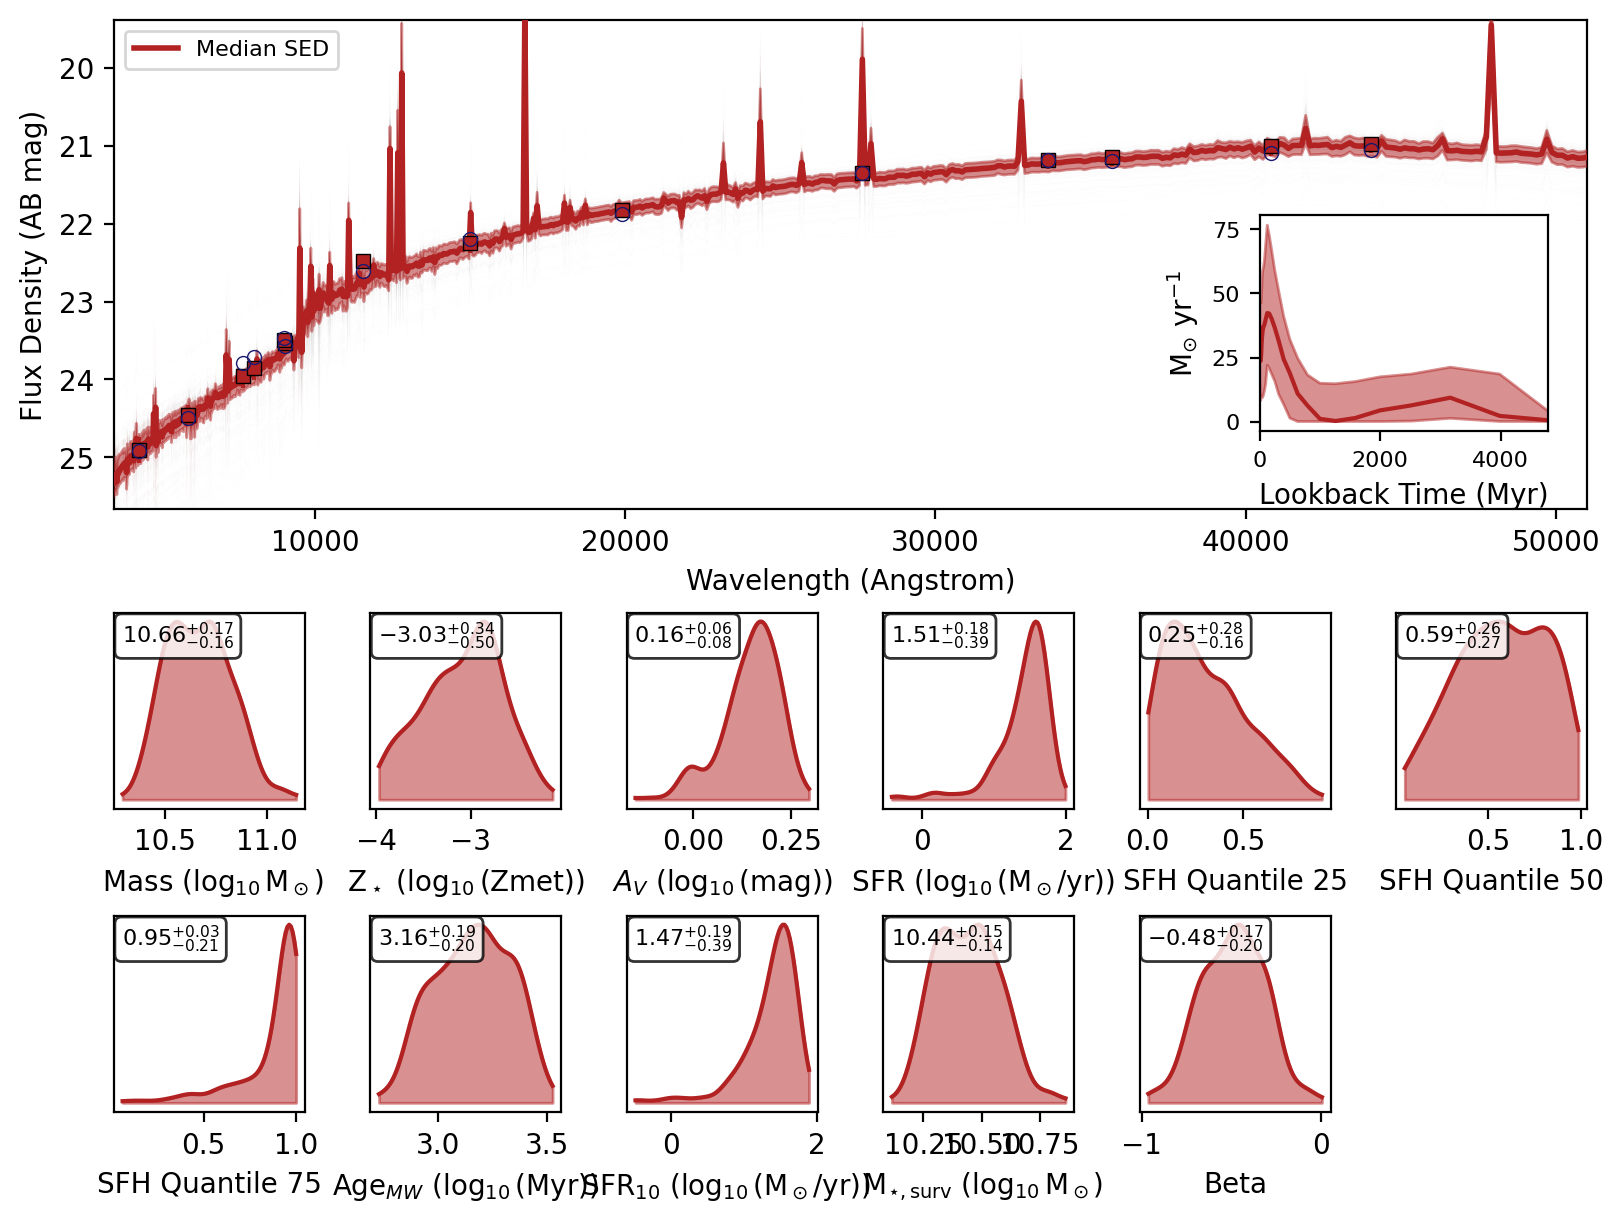

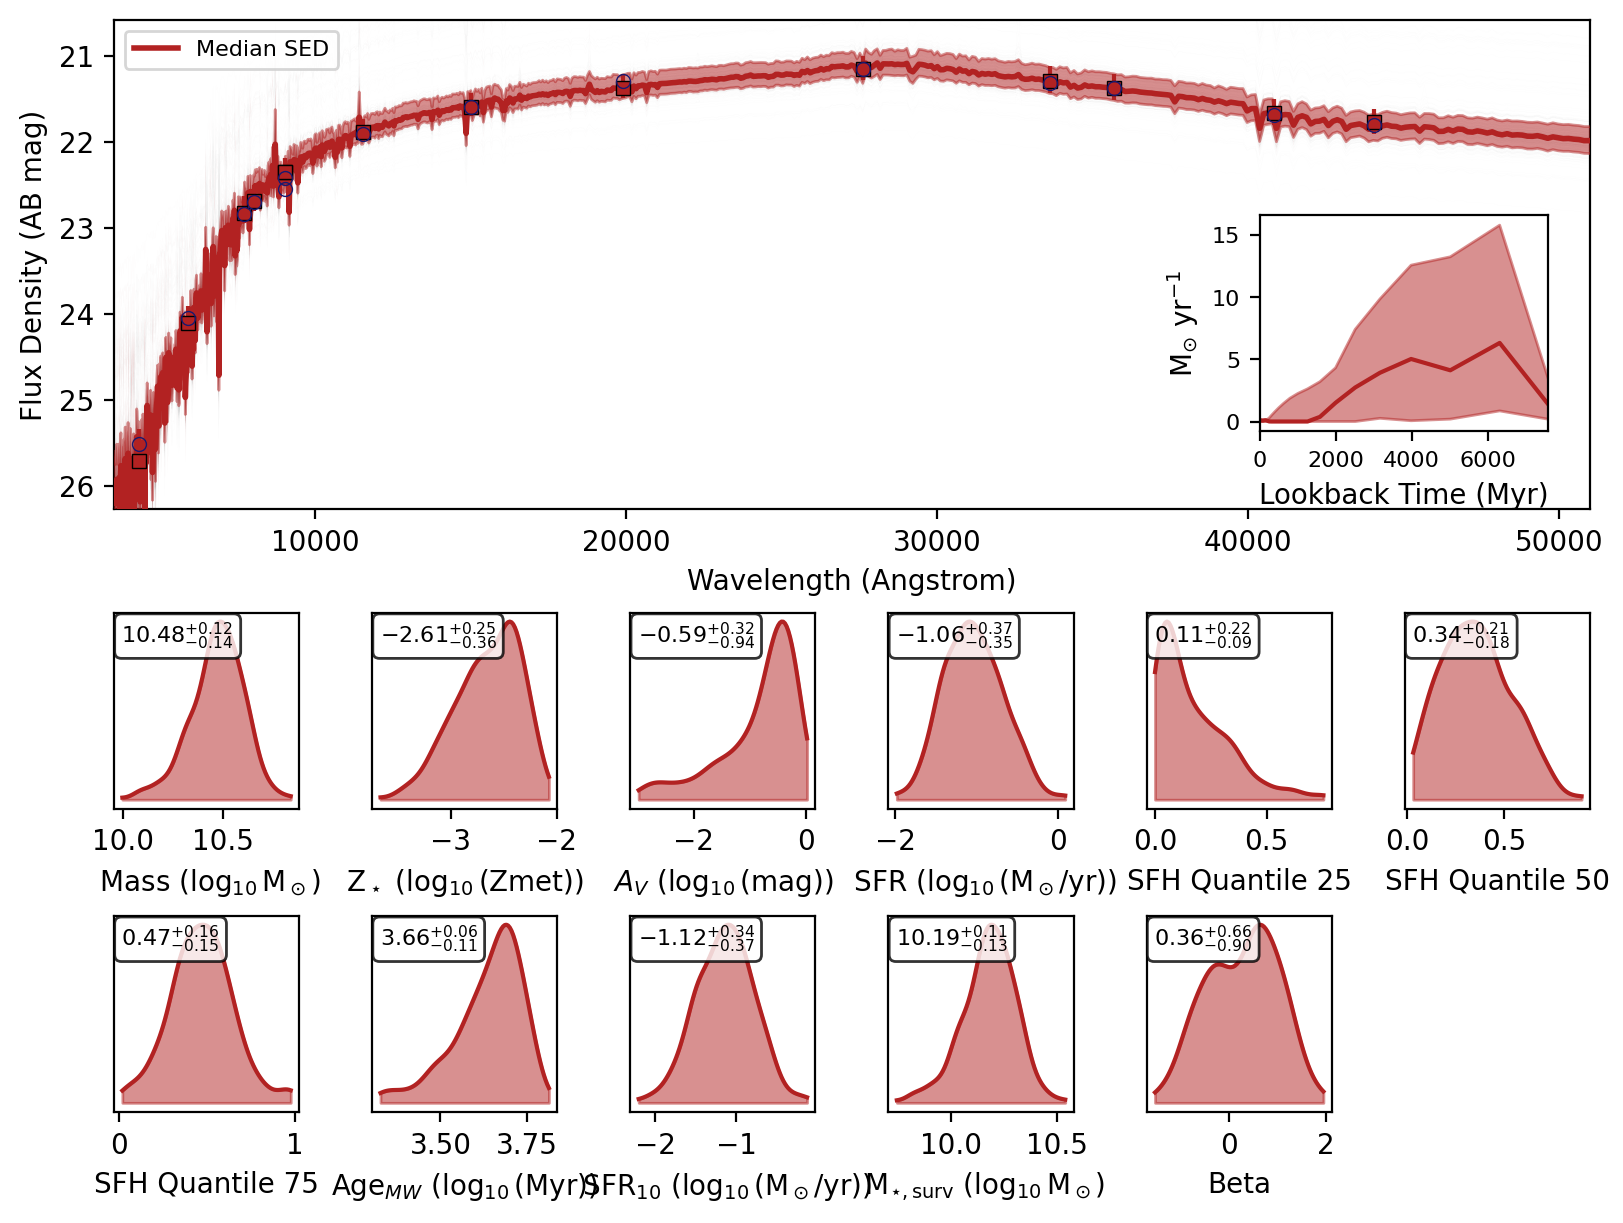

In [11]:
for key in data.keys():
    display(data[key]["fig"])

We can check the feature array used for inference by setting `return_feature_array=True`.

In [12]:
feature_array, mask = post_tab, data = fitter.fit_catalogue(
    cat,
    columns_to_feature_names=conversion_dict,
    flux_units=Jy,
    check_out_of_distribution=False,
    return_feature_array=True,
    missing_data_flag=np.nan,
    num_samples=300,
    append_to_input=False,
)

feature_array

WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB'} arguments will have no effect with this model. Input must be in Jy.
WARNING {'true_flux_units': Jy, 'out_units': 'AB

array([[2.4493111e+01, 2.4163763e+01, 2.3604200e+01, ..., 9.3294436e-04,
        8.9689216e-04, 1.0870000e+00],
       [2.5077990e+01, 2.4549704e+01, 2.3904078e+01, ..., 6.5881168e-03,
        7.1780495e-03, 6.9384003e-01],
       [2.4922672e+01, 2.4493998e+01, 2.3787994e+01, ..., 1.1117980e-03,
        8.8765024e-04, 1.5530000e+00],
       ...,
       [2.6450205e+01, 2.4133789e+01, 2.2739662e+01, ..., 3.6288964e-04,
        2.9280994e-04, 6.6799998e-01],
       [2.7736353e+01, 2.6571772e+01, 2.5916496e+01, ..., 4.7382887e-04,
        3.4990878e-04, 1.6912301e+00],
       [2.3816368e+01, 2.3439030e+01, 2.3062237e+01, ..., 6.9473550e-04,
        6.0235627e-04, 5.7800002e+00]], dtype=float32)

We can also run prior predictive checks to identify outliers, by setting `check_out_of_distribution=True`. The available list of methods is any of those in PYOD (https://pyod.readthedocs.io/en/latest/). You can set them with the 'outlier_methods' argument as a list of strings.